## Mendelian Randomization

This notebook demonstrates how to perform Mendelian randomization (MR) to assess the causal relationship between complex traits.

We pre-downloaded the summary statistics in VCF format from [IEU OpenGWAS proeject](https://gwas.mrcieu.ac.uk):

- Low-Density Lipoprotein (LDL): [ieu-a-300](https://gwas.mrcieu.ac.uk/datasets/ieu-a-300/)
- Coronary Heart Disease (CHD): [ieu-a-7](https://gwas.mrcieu.ac.uk/datasets/ieu-a-7/)
- Myocardial Infarction (MI): [ieu-a-798](https://gwas.mrcieu.ac.uk/datasets/ieu-a-798/)

Thanks to the [IEU OpenGWAS proeject](https://gwas.mrcieu.ac.uk) and based on their [data policy](https://gwas.mrcieu.ac.uk/about/):
> We have made all the public data available for download. We are using the GWAS VCF format to store the GWAS summary data to ensure alignment with the hg19 reference sequence, and to enable very fast querying. More information is available here: https://github.com/MRCIEU/gwas-vcf-specification and on biorxiv.

We also download a list of independent regions of Europeans in hg19 from [nygcresearch](https://bitbucket.org/nygcresearch/ldetect-data/src/master/EUR/fourier_ls-all.bed) with Copyright (c) 2015 Tomaz Berisa.



**References**


1. Lyon, M., Andrews, S. J., Elsworth, B., Gaunt, T. R., Hemani, G., & Marcora, E. (2020). The variant call format provides efficient and robust storage of GWAS summary statistics. bioRxiv. https://doi.org/10.1101/2020.05.29.115824
2. Global Lipids Genetics Consortium. (2013). Discovery and refinement of loci associated with lipid levels. Nature Genetics, 45(12), 1274–1283. https://doi.org/10.1038/ng.2797
3. Bowden, J., Davey Smith, G., & Burgess, S. (2015). Mendelian randomization with invalid instruments: Effect estimation and bias detection through Egger regression. International Journal of Epidemiology, 44(2), 512–525. https://doi.org/10.1093/ije/dyv080
4. Davey Smith, G., & Ebrahim, S. (2003). 'Mendelian randomization': Can genetic epidemiology contribute to understanding environmental determinants of disease? International Journal of Epidemiology, 32(1), 1–22. https://doi.org/10.1093/ije/dyg070
5. Davey Smith, G., & Hemani, G. (2014). Mendelian randomization: Genetic anchors for causal inference in epidemiological studies. Human Molecular Genetics, 23(R1), R89–R98. https://doi.org/10.1093/hmg/ddu328
6. Pierce, B. L., & Burgess, S. (2013). Efficient design for Mendelian randomization studies: Subsample and 2-sample instrumental variable estimators. American Journal of Epidemiology, 178(7), 1177–1184. https://doi.org/10.1093/aje/kwt084



In [1]:
# updated
rm(list=ls())

library(TwoSampleMR)
library(MendelianRandomization)
library(ggplot2)
library(data.table)
library(MRInstruments) 
library(dplyr)
library(tidyr)

TwoSampleMR version 0.6.8 


  [>] New authentication requirements: https://mrcieu.github.io/ieugwasr/articles/guide.html#authentication.

  [>] Major upgrades to our servers completed to improve service and stability.

  [>] We need your help to shape our emerging roadmap!

      Please take 2 minutes to give us feedback -

      https://forms.office.com/e/eSr7EFAfCG


Attaching package: ‘MendelianRandomization’


The following objects are masked from ‘package:TwoSampleMR’:

    mr_ivw, mr_median



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
load_vcf <- function(file_path, col_name, rows = -1) {
  # Read VCF file using fread, skipping header lines
  vcf_data <- fread(
    file = file_path, 
    skip = "#CHROM", 
    header = TRUE, 
    nrows = rows
  )

 # Split the 'INFO' column into separate components
vcf_data <- vcf_data %>%
  separate(INFO, into = c("AF"), sep = "=", fill = "right", extra = "drop") %>%
  mutate(AF = as.numeric(AF))  # Convert AF to numeric

vcf_data <- vcf_data %>%
  separate(
    col_name, 
    into = c("ES", "SE", "LP", "AF2", "SS", "ID2"),
    sep = ":",
    fill = "right"
  ) %>%
  mutate(across(c(ES, SE, LP, AF2, SS), as.numeric))  # Convert relevant columns to numeric
  return(vcf_data)
}

# MR from LDL to CHD

Firstly we run the Mendelian Randomization between LDL (low-density lipoprotein) and CHD (coronary heart disease).

The summary statistics of LDL comes from this paper, and we pre-downloaded it in VCF format from [here](https://gwas.mrcieu.ac.uk/datasets/ieu-a-300/)
> Global Lipids Genetics Consortium. Discovery and refinement of loci associated with lipid levels. Nat Genet 45, 1274–1283 (2013). https://doi.org/10.1038/ng.2797

The data preview can be found here https://gwas.mrcieu.ac.uk/files/ieu-a-300/ieu-a-300_report.html#diagnostics

## Import the exposure data and format

In [3]:
# Specify the file path
exposure_data_path <- "./ieu-a-300.vcf.gz"

# Load the VCF summary statistics
exposure_data_formatted <- load_vcf(exposure_data_path, col_name= "ieu-a-300")

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `AF = as.numeric(AF)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(c(ES, SE, LP, AF2, SS), as.numeric)`.
Caused by warning:
! NAs introduced by coercion”


In [4]:
exposure_data_formatted <- exposure_data_formatted %>%
    dplyr::mutate(pval.exposure = 10^(-LP), id.exposure = "LDL", exposure = "LDL") %>%
    rename(CHROM = `#CHROM`) %>%
    rename(
        SNP = ID,
        effect_allele.exposure = ALT, # Effect allele
        other_allele.exposure = REF, # Other allele
        beta.exposure = ES, # Effect size (ES)
        se.exposure = SE,
        eaf.exposure = AF2
    )

head(exposure_data_formatted, 3)
dim(exposure_data_formatted)

,CHROM,POS,SNP,other_allele.exposure,effect_allele.exposure,QUAL,FILTER,AF,FORMAT,beta.exposure,se.exposure,LP,eaf.exposure,SS,ID2,pval.exposure,id.exposure,exposure
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,1,721290,rs12565286,G,C,.,PASS,NA,ES:SE:LP:AF:SS:ID,-0.0325,0.0194,1.201000,0.04354,54632.1,rs12565286,0.06295062,LDL,LDL
2,1,752566,rs3094315,G,A,.,PASS,NA,ES:SE:LP:AF:SS:ID,0.0156,0.0100,0.572189,0.83640,52845.0,rs3094315,0.26780026,LDL,LDL
3,1,785050,rs2905062,G,A,.,PASS,NA,ES:SE:LP:AF:SS:ID,0.0178,0.0075,1.562570,0.86680,91375.0,rs2905062,0.02737978,LDL,LDL


[1] 2414488      18

## Independent variants

In the TwoSampleMR package you can also use function [clump_date](https://mrcieu.github.io/TwoSampleMR/reference/clump_data.html) with token setup for yourself. However, here we provide a list of independent regions for Europeans (download link: https://bitbucket.org/nygcresearch/ldetect-data/src/master/) and select the top variant in each region to be instrumental variables, so that they will be independent from each other.

In [5]:
independent_regions <- fread("./fourier_ls-all.bed")

To save us some computational time, we only filter out the variants with p-value below 0.05 (because the instrumental variables need to be significant in MR).

In [6]:
exposure_data_formatted_p_0.05 <- exposure_data_formatted %>%
    filter(pval.exposure < 0.05)

In [7]:
independent_regions = independent_regions %>%
    mutate(CHR=as.integer(sub(pattern = "chr", replacement = "", chr))) %>%
    select(!chr)
independent_regions$SNPID = NA
independent_regions$minp = NA

time_1 <- Sys.time()
for (index in 1:nrow(independent_regions)) {
    chr_index = independent_regions$CHR[index]
    start_pos = independent_regions$start[index]
    end_pos = independent_regions$stop[index]
    tmp = exposure_data_formatted_p_0.05 %>%
        filter(CHROM==chr_index & as.integer(POS) >= start_pos & as.integer(POS) < end_pos)
    if (nrow(tmp) != 0) {
        # Find the variant with the smallest p-value
        best_variant <- tmp[which.min(tmp$pval.exposure), ]
        
        # Assign the SNPID and minp for the selected variant
        independent_regions$SNPID[index] = best_variant$ID
        independent_regions$minp[index] = best_variant$pval.exposure
    }
}
time_2 <- Sys.time()
independent_regions_noNA <- independent_regions %>%
    filter(!is.na(SNPID))
print(paste0("Among all ", as.character(nrow(independent_regions)), 
             " independent regions, "," this returns ", as.character(nrow(independent_regions_noNA)), 
             " regions that cover at least one SNP that has a p-value smaller than 0.05. Then we extract the top SNP with the smallest p-value in each region."))

[1] "Among all 1703 independent regions,  this returns 1486 regions that cover at least one SNP that has a p-value smaller than 0.05. Then we extract the top SNP with the smallest p-value in each region."


In [8]:
exposure_data_formatted_selected_IV <- exposure_data_formatted_p_0.05 %>%
    filter(SNP %in% independent_regions_noNA$SNPID)

## Import the outcome data

The CHD data can be downloaded from [here](https://gwas.mrcieu.ac.uk/datasets/ieu-a-7/). 

In [10]:
# Specify the file path
outcome_data_path_1 <- "./ieu-a-7.vcf.gz"

# Load the VCF summary statistics
outcome_data_formatted_1 <- load_vcf(outcome_data_path_1, col_name = "ieu-a-7")

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `AF = as.numeric(AF)`.
Caused by warning:
! NAs introduced by coercion”


## Harmonize the data

In [11]:
# Outcome data formatting with correct column names for TwoSampleMR
outcome_data_formatted_1 <- outcome_data_formatted_1 %>%
    dplyr::mutate(pval.outcome = 10^(-LP), id.outcome = "CHD", outcome = "CHD") %>%
    rename(CHROM = `#CHROM`) %>%
    rename(
        SNP = ID,
        effect_allele.outcome = ALT, # Effect allele
        other_allele.outcome = REF, # Other allele
        beta.outcome = ES, # Effect size (ES)
        se.outcome = SE,
        eaf.outcome = AF2
    )
head(outcome_data_formatted_1, 3)

,CHROM,POS,SNP,other_allele.outcome,effect_allele.outcome,QUAL,FILTER,AF,FORMAT,beta.outcome,se.outcome,LP,eaf.outcome,SS,ID2,pval.outcome,id.outcome,outcome
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,1,752566,rs3094315,G,A,.,PASS,NA,ES:SE:LP:AF:SS:ID,-0.005243,0.0157652,0.1310850,0.763018,184305,rs3094315,0.7394605,CHD,CHD
2,1,752721,rs3131972,A,G,.,PASS,NA,ES:SE:LP:AF:SS:ID,-0.003032,0.0156381,0.0724935,0.740969,184305,rs3131972,0.8462652,CHD,CHD
3,1,752894,rs3131971,T,C,.,PASS,NA,ES:SE:LP:AF:SS:ID,0.004640,0.0162377,0.1106610,0.744287,184305,rs3131971,0.7750666,CHD,CHD


In [12]:
# Harmonize the data
harmonized_data_1 <- harmonise_data(exposure_data_formatted_selected_IV, outcome_data_formatted_1)

Harmonising LDL (LDL) and CHD (CHD)

Removing the following SNPs for being palindromic with intermediate allele frequencies:
rs12480689, rs2954029, rs360276, rs3845356, rs3927680, rs6550635, rs847812



In [13]:
head(harmonized_data_1, 3)
dim(harmonized_data_1)

,SNP,effect_allele.exposure,other_allele.exposure,effect_allele.outcome,other_allele.outcome,beta.exposure,beta.outcome,eaf.exposure,eaf.outcome,remove,⋯,LP.y,SS.y,ID2.y,pval.exposure,id.exposure,exposure,action,SNP_index,mr_keep,samplesize.outcome
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,⋯,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<lgl>,<lgl>
1,rs10012461,T,G,T,G,0.0429,0.021325,0.03694,0.052375,FALSE,⋯,2.52900,89888,rs10012461,2.958012e-03,LDL,LDL,2,1,TRUE,NA
2,rs10026790,A,G,A,G,-0.0210,-0.037817,0.24800,0.257442,FALSE,⋯,5.59261,173049,rs10026790,2.554995e-06,LDL,LDL,2,1,TRUE,NA
3,rs1003649,G,A,G,A,0.0601,0.000302,0.02902,0.041565,FALSE,⋯,2.30671,82359,rs1003649,4.935032e-03,LDL,LDL,2,1,TRUE,NA


[1] 1474   42

In [14]:
harmonized_data_1 <- harmonized_data_1 %>% filter(mr_keep = TRUE)

## Run MR analysis

In [15]:
####MR ANALYSIS####
res1 <- suppressWarnings(mr(harmonized_data_1, method_list=c("mr_ivw", "mr_egger_regression", "mr_weighted_median")))

Analysing 'LDL' on 'CHD'



id.exposure,id.outcome,outcome,exposure,method,nsnp,b,se,pval,lo_ci,up_ci,or,or_lci95,or_uci95
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LDL,CHD,CHD,LDL,Inverse variance weighted,1467,0.1756588,0.01614546,1.439282e-27,0.1440137,0.2073039,1.192031,1.154900,1.230356
LDL,CHD,CHD,LDL,MR Egger,1467,0.2811012,0.02976176,1.349550e-20,0.2227682,0.3394343,1.324588,1.249531,1.404153
LDL,CHD,CHD,LDL,Weighted median,1467,0.1882435,0.02773526,1.143658e-11,0.1338824,0.2426046,1.207127,1.143258,1.274565


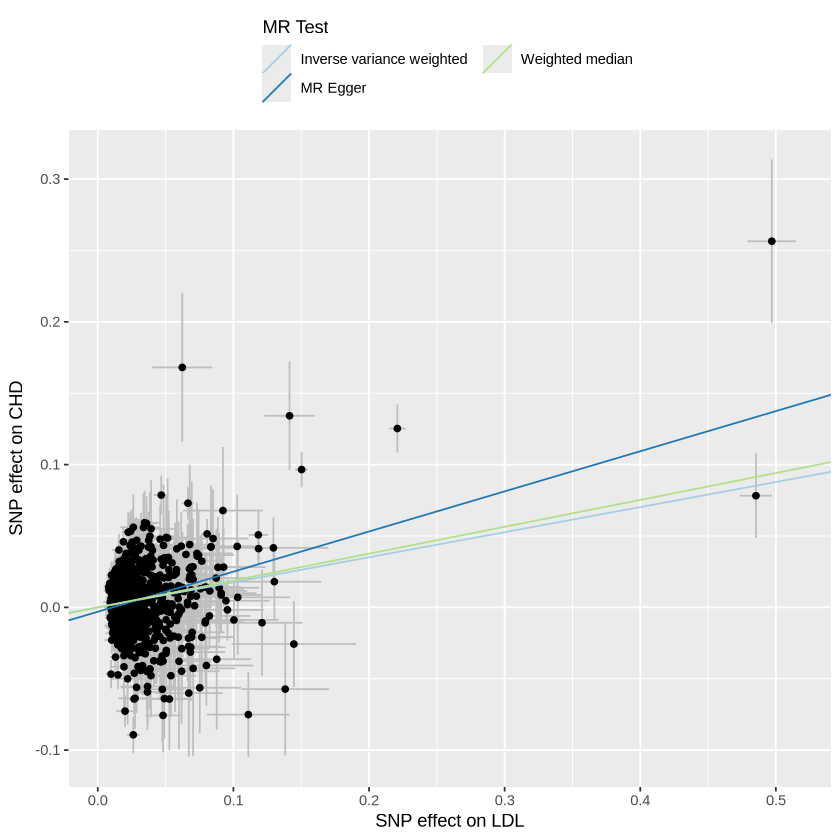

In [16]:
generate_odds_ratios(res1)
p1 <- mr_scatter_plot(res1, harmonized_data_1)
p1[[1]]

# MR from LDL to MI

In this section we run MR to detect the association between LDL and MI.

The MI data is downloaded from [here](https://gwas.mrcieu.ac.uk/datasets/ieu-a-798/).

## Import the outcome data

In [17]:
# Specify the file path
outcome_data_path_2 <- "./ieu-a-798.vcf.gz"

# Load the VCF summary statistics
outcome_data_formatted_2 <- load_vcf(outcome_data_path_2, col_name = "ieu-a-798")

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `AF = as.numeric(AF)`.
Caused by warning:
! NAs introduced by coercion”


## Harmonize the data

In [18]:
# Outcome data formatting with correct column names for TwoSampleMR
outcome_data_formatted_2 <- outcome_data_formatted_2 %>%
    dplyr::mutate(pval.outcome = 10^(-LP), id.outcome = "MI", outcome = "MI") %>%
    rename(CHROM = `#CHROM`) %>%
    rename(
        SNP = ID,
        effect_allele.outcome = ALT, # Effect allele
        other_allele.outcome = REF, # Other allele
        beta.outcome = ES, # Effect size (ES)
        se.outcome = SE,
        eaf.outcome = AF2
    )

In [19]:
# Harmonize the data
harmonized_data_2 <- harmonise_data(exposure_data_formatted_selected_IV, outcome_data_formatted_2)

Harmonising LDL (LDL) and MI (MI)

Removing the following SNPs for being palindromic with intermediate allele frequencies:
rs12480689, rs2954029, rs360276, rs3845356, rs3927680, rs6550635, rs847812



In [20]:
harmonized_data_2 <- harmonized_data_2 %>% filter(mr_keep = TRUE)

## Run MR analysis

In [21]:
res2 <- mr(harmonized_data_2, method_list=c("mr_ivw", "mr_egger_regression", "mr_weighted_median"))

Analysing 'LDL' on 'MI'



id.exposure,id.outcome,outcome,exposure,method,nsnp,b,se,pval,lo_ci,up_ci,or,or_lci95,or_uci95
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LDL,MI,MI,LDL,Inverse variance weighted,1467,0.1601939,0.01737381,2.959207e-20,0.1261413,0.1942466,1.173738,1.134442,1.214396
LDL,MI,MI,LDL,MR Egger,1467,0.2479894,0.03236030,3.276050e-14,0.1845633,0.3114156,1.281446,1.202693,1.365357
LDL,MI,MI,LDL,Weighted median,1467,0.1612875,0.02922717,3.420839e-08,0.1040022,0.2185727,1.175023,1.109603,1.244300


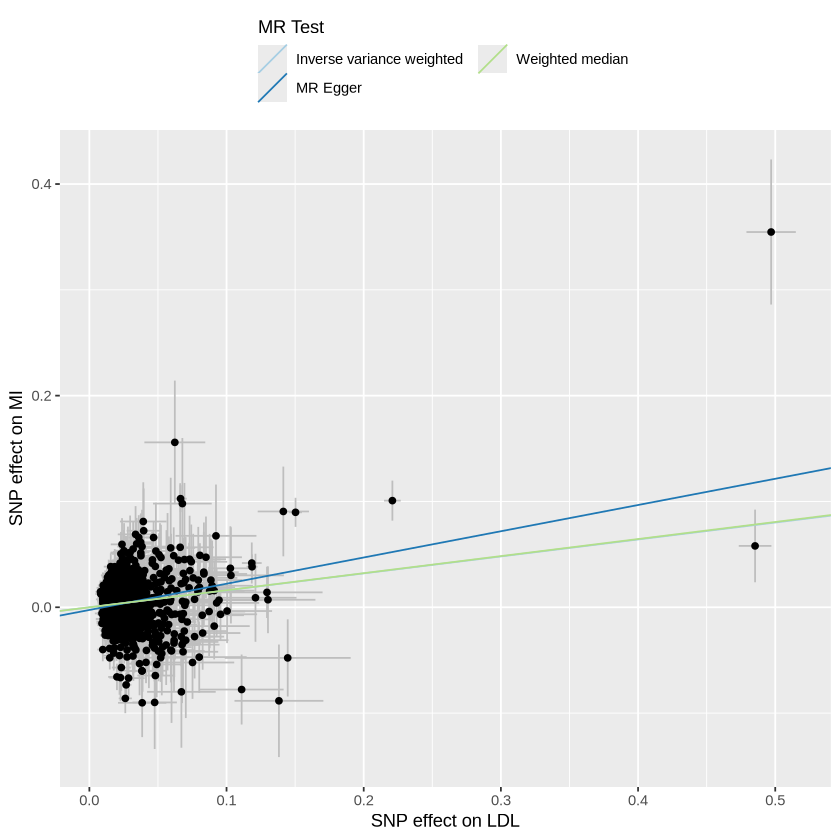

In [22]:
generate_odds_ratios(res2)
p2 <- mr_scatter_plot(res2, harmonized_data_2)
p2[[1]]

## Sensitivity analysis

In [23]:
mr_heterogeneity(harmonized_data_2) # Test for heterogeneity
mr_pleiotropy_test(harmonized_data_2) # Test for pleiotropy

id.exposure,id.outcome,outcome,exposure,method,Q,Q_df,Q_pval
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
LDL,MI,MI,LDL,MR Egger,2049.632,1465,2.73920e-22
LDL,MI,MI,LDL,Inverse variance weighted,2064.064,1466,3.98777e-23


id.exposure,id.outcome,outcome,exposure,egger_intercept,se,pval
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
LDL,MI,MI,LDL,-0.002522809,0.0007854957,0.001347985
